In [1]:
import ast
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import warnings
from tqdm import tqdm
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 5000)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

In [2]:
# Read in the data CSV files
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
ss = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

In [3]:
print("train.csv shape: ", train.shape)
print("train_labels.csv shape: ", train_labels.shape)
print("test.csv shape: ", test.shape)
print("specs.csv shape: ", specs.shape)

train.csv shape:  (11341042, 11)
train_labels.csv shape:  (17690, 7)
test.csv shape:  (1156414, 11)
specs.csv shape:  (386, 3)


## train.csv

- event_id - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
- game_session - Randomly generated unique identifier grouping events within a single game or video play session.
- timestamp - Client-generated datetime
- event_data - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.
- installation_id - Randomly generated unique identifier grouping game sessions within a single installed application instance.
- event_count - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
- event_code - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
- game_time - Time in milliseconds since the start of the game session. Extracted from event_data.
- title - Title of the game or video.
- type - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- world - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [4]:
train.head(10)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK
5,1325467d,0848ef14a8dc6892,2019-09-06T17:55:06.279Z,"{""coordinates"":{""x"":583,""y"":605,""stage_width"":...",0001e90f,4,4070,9991,Sandcastle Builder (Activity),Activity,MAGMAPEAK
6,1325467d,0848ef14a8dc6892,2019-09-06T17:55:06.913Z,"{""coordinates"":{""x"":601,""y"":570,""stage_width"":...",0001e90f,5,4070,10622,Sandcastle Builder (Activity),Activity,MAGMAPEAK
7,1325467d,0848ef14a8dc6892,2019-09-06T17:55:07.546Z,"{""coordinates"":{""x"":250,""y"":665,""stage_width"":...",0001e90f,6,4070,11255,Sandcastle Builder (Activity),Activity,MAGMAPEAK
8,1325467d,0848ef14a8dc6892,2019-09-06T17:55:07.979Z,"{""coordinates"":{""x"":279,""y"":629,""stage_width"":...",0001e90f,7,4070,11689,Sandcastle Builder (Activity),Activity,MAGMAPEAK
9,1325467d,0848ef14a8dc6892,2019-09-06T17:55:08.566Z,"{""coordinates"":{""x"":839,""y"":654,""stage_width"":...",0001e90f,8,4070,12272,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341042 entries, 0 to 11341041
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: int64(3), object(8)
memory usage: 951.8+ MB


In [6]:
train.describe()

,event_count,event_code,game_time
count,1.134104e+07,1.134104e+07,1.134104e+07
mean,1.056642e+02,3.513838e+03,1.976236e+05
std,1.483477e+02,6.816470e+02,1.803968e+06
min,1.000000e+00,2.000000e+03,0.000000e+00
25%,2.500000e+01,3.021000e+03,3.061800e+04
50%,6.100000e+01,4.020000e+03,7.276100e+04
75%,1.290000e+02,4.035000e+03,1.574460e+05
max,3.368000e+03,5.010000e+03,3.069102e+08


## missing values

In [7]:
train.isnull().sum() # no missing values in all the datasets

event_id           0
game_session       0
timestamp          0
event_data         0
installation_id    0
event_count        0
event_code         0
game_time          0
title              0
type               0
world              0
dtype: int64

In [8]:
# to check if event_id & game_session are randomly gegerated
train['event_id_as_int'] = train['event_id'].apply(lambda x: int(x, 16))
train['game_session_as_int'] = train['game_session'].apply(lambda x: int(x, 16))

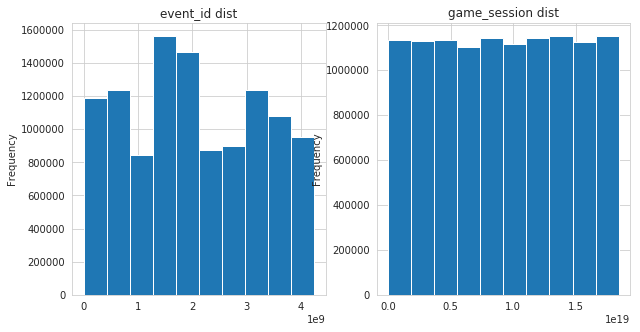

In [9]:
# However, nothing intertesting is showed.
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
train['event_id_as_int'].plot(kind="hist", title="event_id dist")
plt.subplot(1,2,2)
train['game_session_as_int'].plot(kind="hist", title="game_session dist")

In [10]:
print(train["event_id"].value_counts().head(10))
print(train["event_id"].value_counts().tail(10))

1325467d    274673
bb3e370b    256179
cf82af56    224694
5e812b27    206129
cfbd47c8    199734
90efca10    185211
27253bdc    183676
76babcde    182235
b2dba42b    169921
1bb5fbdb    168344
Name: event_id, dtype: int64
0ce40006    4
611485c5    3
17ca3959    1
a8cc6fec    1
119b5b02    1
1b54d27f    1
003cd2ee    1
5dc079d8    1
4074bac2    1
dcb1663e    1
Name: event_id, dtype: int64


In [11]:
train[train["event_id"] == "bb3e370b"].iloc[0]["event_data"]

'{"bottle":{"amount":1,"color":"pink"},"bottles":[{"color":"blue","amount":2},{"color":"blue","amount":1},{"color":"purple","amount":2},{"color":"purple","amount":1},{"color":"orange","amount":1},{"color":"orange","amount":2},{"color":"pink","amount":1},{"color":"pink","amount":2},{"color":"yellow","amount":1},{"color":"yellow","amount":2},{"color":"green","amount":1},{"color":"green","amount":2}],"coordinates":{"x":401,"y":602,"stage_width":1015,"stage_height":762},"source":7,"round":1,"event_count":4,"game_time":3914,"event_code":4030}'

In [12]:
print(train["game_session"].value_counts().head(10))
print(train["game_session"].value_counts().tail(10))

6e6e697f2e593de1    3368
bb1f09ec062b6660    3182
33495c8f126e2ef9    2505
34c82b23355e378c    2456
8fe0ab3c3e448a04    2398
6e98fc08f99fd7c2    2375
1520f3d49669573d    2250
39d2cbe5ce1896ea    2177
7f27efcf7b2b7798    2073
1f59d4f65ccbcb74    2060
Name: game_session, dtype: int64
3b1f6b1b23c1a12d    1
83a8c7c82959c624    1
7656ecb218ff92ae    1
bcc3286cc473c131    1
f325655313e01520    1
c744b1ef6905c247    1
7e665810c1e2dfbb    1
c384fd7c4a567c66    1
216c17e0aeab5ae8    1
450f1dd9e344e2be    1
Name: game_session, dtype: int64


In [13]:
# timestamp
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['date'] = train['timestamp'].dt.date
train['hour'] = train['timestamp'].dt.hour
train['weekday_name'] = train['timestamp'].dt.weekday_name

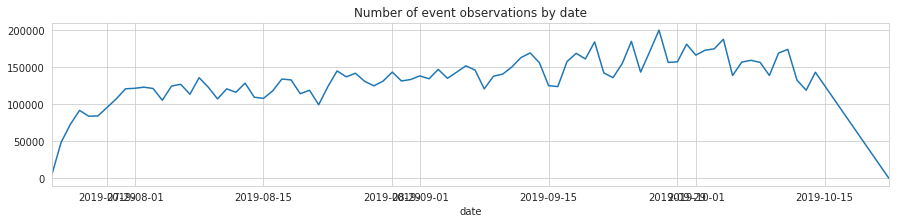

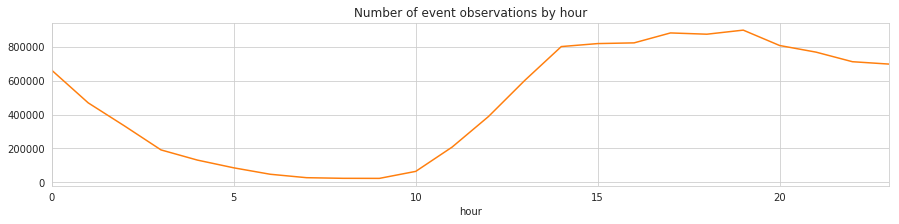

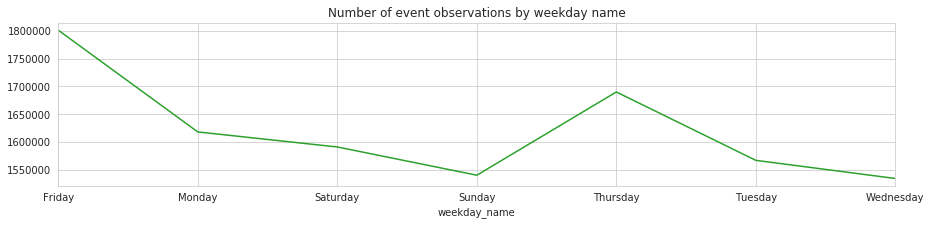

In [14]:
train.groupby('date')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by date", color=my_pal[0])
plt.show()
train.groupby('hour')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by hour", color=my_pal[1])
plt.show()
train.groupby('weekday_name')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by weekday name", color=my_pal[2])
plt.show()

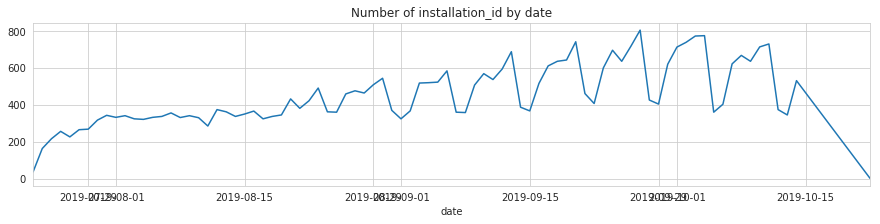

In [15]:
# can be seen as cyclic trend in the middle part of analysis period
train.groupby('date')['installation_id'].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of installation_id by date", color=my_pal[0])
plt.show()

In [16]:
# date range
test['timestamp'] = pd.to_datetime(test['timestamp'])
print(f'The date range in train is: {train.timestamp.dt.date.min()} to {train.timestamp.dt.date.max()}')
print(f'The date range in test is: {test.timestamp.dt.date.min()} to {test.timestamp.dt.date.max()}')
# we are talking about a dataset that seems (randomly) split on installation_id. 
# Well actually "sort of" as Kaggle seems to have done this on installation_id's with assessments first, and added the "left-overs" with no assessments taken to the train set.

The date range in train is: 2019-07-23 to 2019-10-22
The date range in test is: 2019-07-24 to 2019-10-14


In [17]:
# event data: which seems to have the most interesting information, however, considering the RAM limit, it's necessary to exract only the influential information.
print(train["event_data"].value_counts().head(10))
print(train["event_data"].value_counts().tail(10))

{"event_code": 2000, "event_count": 1}                                                                                                                                                                                                                                              183676
{"version":"1.0","event_count":1,"game_time":0,"event_code":2000}                                                                                                                                                                                                                    59872
{"version":"1.0","round":0,"event_count":1,"game_time":0,"event_code":2000}                                                                                                                                                                                                          45959
{"version":"1","round":0,"event_count":1,"game_time":0,"event_code":2000}                                                                              

In [18]:
print(train[train.event_id == "25fa8af4"].iloc[1]["event_data"])

{"correct":true,"stumps":[1,2,4],"event_count":30,"game_time":18026,"event_code":4100}


In [19]:
# installation_id: need to truncate
print("all installation id            : ", train["installation_id"].nunique())
print("installation id with assessment: ", train[train.type=="Assessment"]["installation_id"].nunique())

all installation id            :  17000
installation id with assessment:  4242


In [20]:
# there are no installation_id's that appear in both train and test.
set(list(train.installation_id.unique())).intersection(set(list(test.installation_id.unique())))

set()

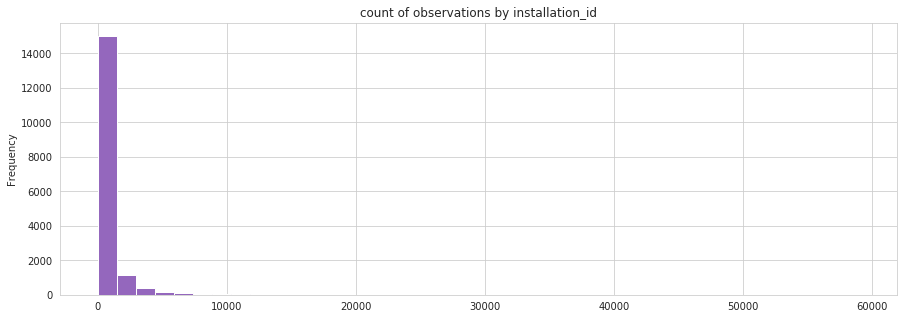

In [21]:
# count of each installation_id
train.groupby('installation_id').count()['event_id'].plot(kind="hist",
          bins=40,
          color=my_pal[4],
          figsize=(15, 5), title="count of observations by installation_id")

# taking log transformation makes the distribution normal
#train.groupby('installation_id').count()['event_id'].apply(np.log1p).plot(kind="hist",
#          bins=40,
#          color=my_pal[4],
#          figsize=(15, 5), title="count of observations by installation_id")

In [22]:
# what is the highest number of cases of installation_id
print(train['installation_id'].value_counts().head(10))
print(train['installation_id'].value_counts().tail(10))

f1c21eda    58988
4d7d3d97    32749
d25338cb    31826
cff5a334    30918
c9ea32e9    30402
9f399a3a    26455
96979008    25404
063e3e02    24988
2d6d1ecd    24356
4bbf5c31    24098
Name: installation_id, dtype: int64
72877d8d    1
85b4b8a9    1
55ae3b7c    1
576bc528    1
38901596    1
a21df797    1
b6ea909a    1
3d627c80    1
9426165e    1
ff3a1cf3    1
Name: installation_id, dtype: int64


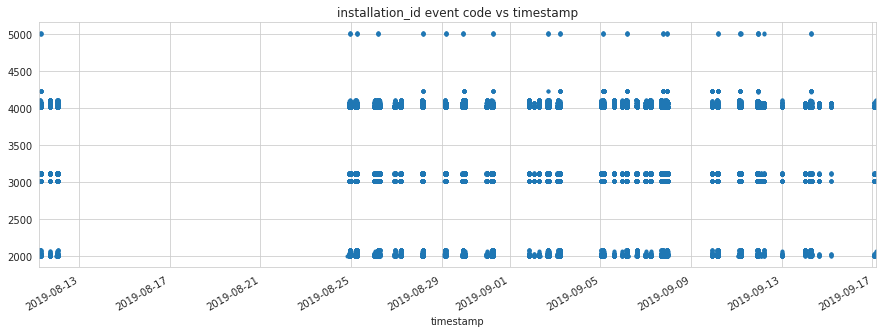

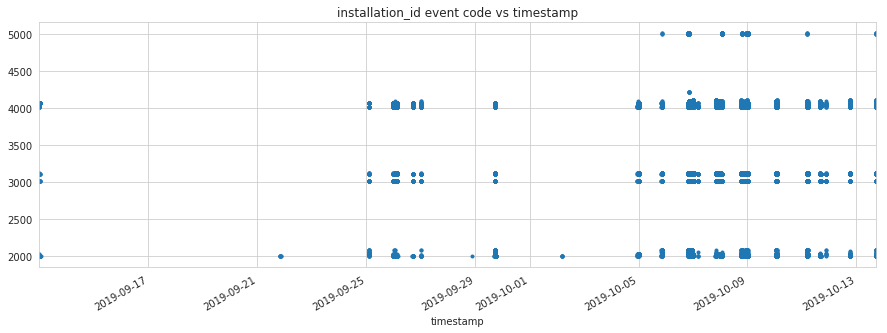

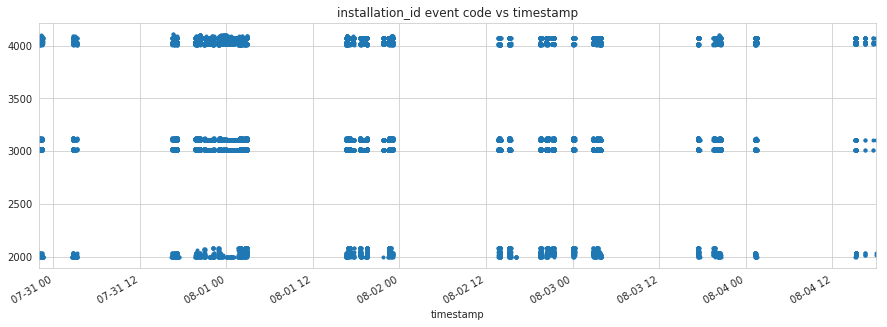

In [23]:
train.query('installation_id == "f1c21eda"').set_index("timestamp")["event_code"].plot(figsize=(15,5), title="installation_id event code vs timestamp", style=".")
plt.show()
train.query('installation_id == "4d7d3d97"').set_index("timestamp")["event_code"].plot(figsize=(15,5), title="installation_id event code vs timestamp", style=".")
plt.show()
train.query('installation_id == "d25338cb"').set_index("timestamp")["event_code"].plot(figsize=(15,5), title="installation_id event code vs timestamp", style=".")
plt.show()

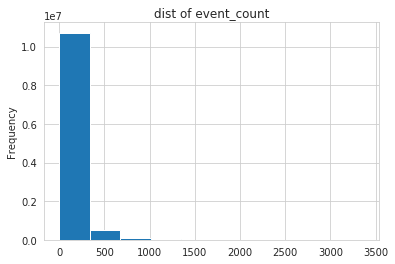

In [24]:
# event_count
train["event_count"].plot(kind="hist", bins=10, title="dist of event_count")

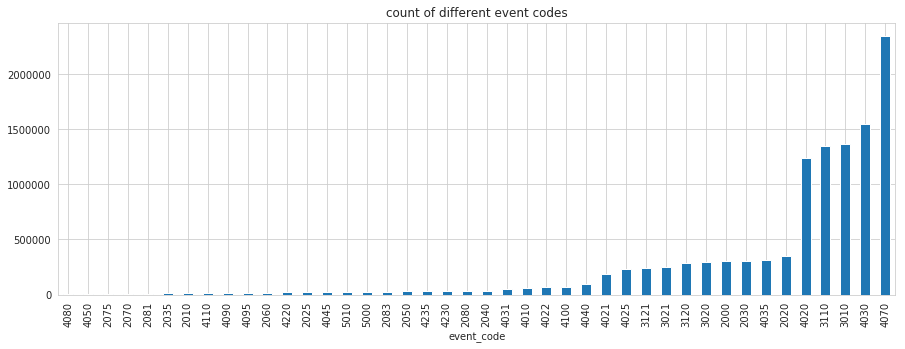

In [25]:
# event_code: looks loke dictionary format but string
train.groupby("event_code").count()["event_id"].sort_values().plot(kind="bar", figsize=(15,5), title="count of different event codes")

4070 and 4030 always come with coordinates (x, y) adn stage_width
possibly they could be marking achievement or something related to position on the screen. These events look like this
{"coordinates":{"x":583,"y":605,"stage_width":1015,"stage_height":762},"event_count":4,"game_time":9991,"event_code":4070}

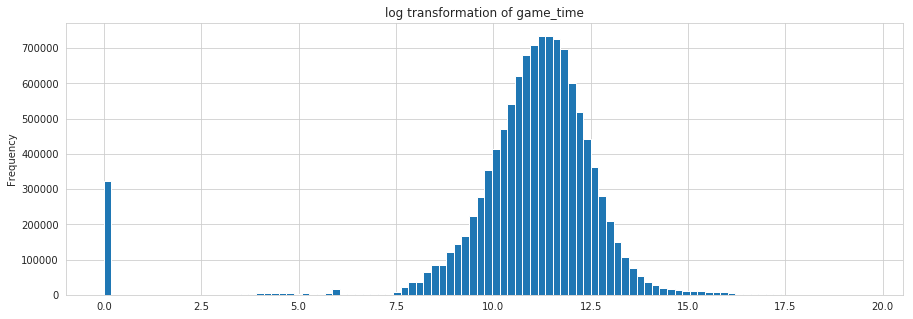

In [26]:
# game_time: almost similar to normal distribution
train["game_time"].apply(np.log1p).plot(kind="hist", figsize=(15,5), bins=100, title="log transformation of game_time")

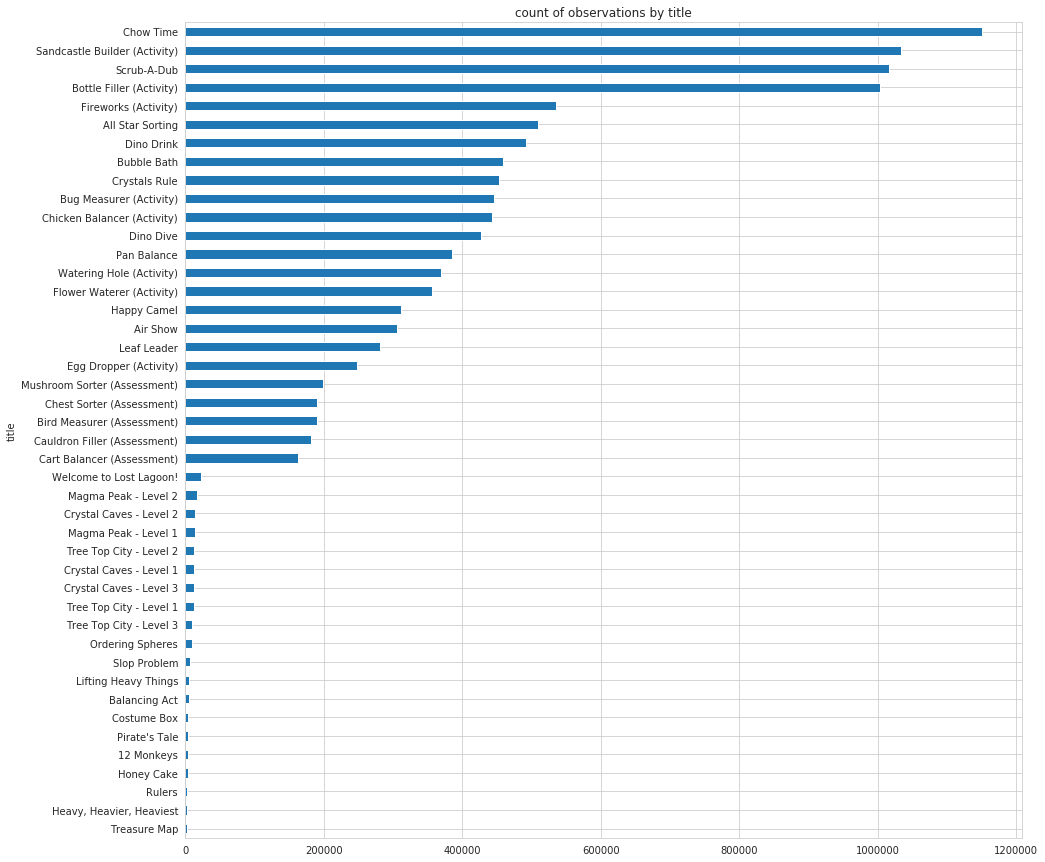

In [27]:
# game/video titles
train.groupby("title")["event_id"].count().sort_values().plot(kind="barh", title="count of observations by title", figsize=(15,15))

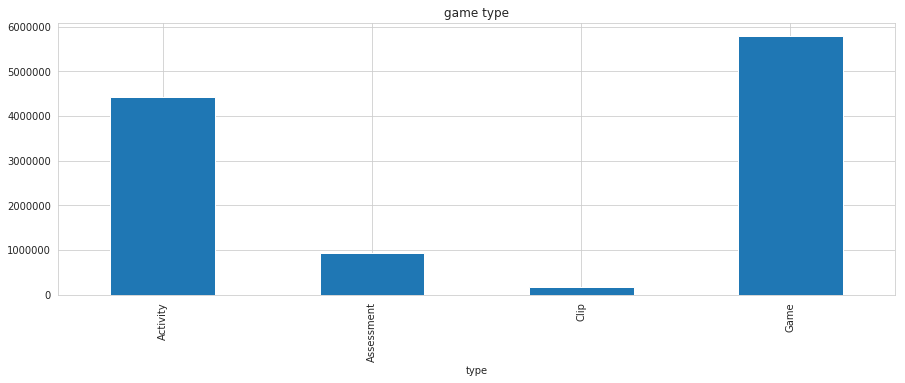

In [28]:
# game type = train["type"].value_counts()
train.groupby("type").count()["event_id"].plot(kind="bar", figsize=(15,5), title = "game type")

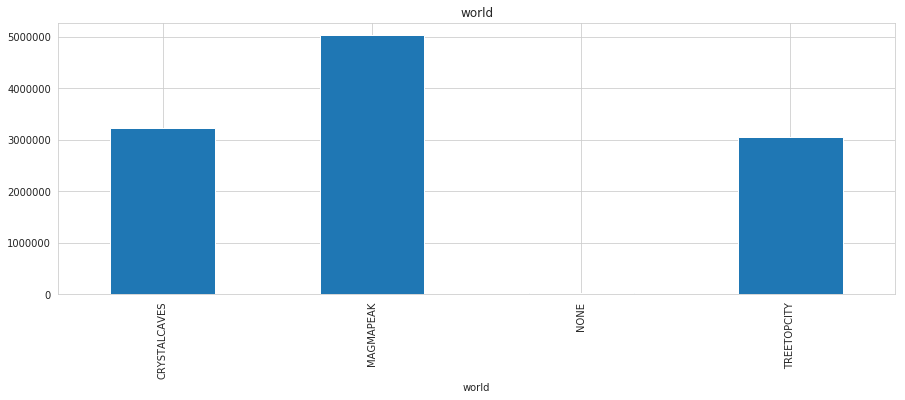

In [29]:
# world  = train.world.value_counts()
train.groupby("world").count()["event_id"].plot(kind="bar", figsize=(15,5), title = "world")

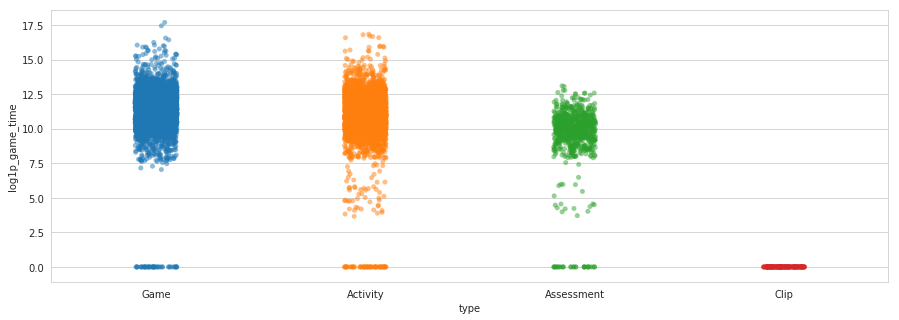

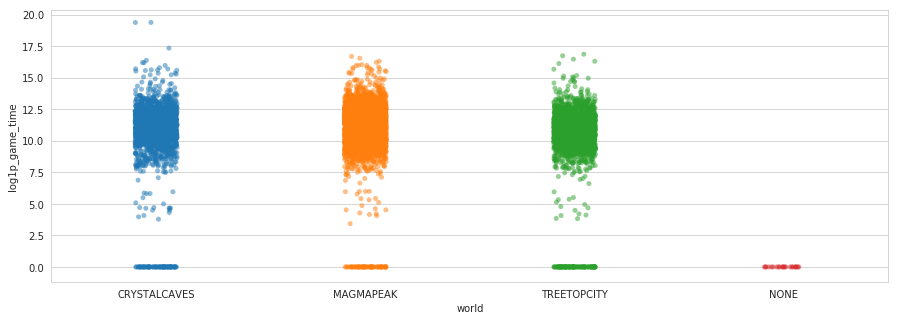

In [30]:
train["log1p_game_time"] = train["game_time"].apply(np.log1p)
fig, ax = plt.subplots(figsize=(15,5))
sns.catplot(x="type", y = "log1p_game_time", data=train.sample(10000), alpha=0.5, ax=ax)
plt.close()
fig, ax = plt.subplots(figsize=(15,5))
sns.catplot(x="world", y="log1p_game_time", data=train.sample(10000), alpha=0.5, ax=ax)
plt.close()

In [31]:
train.groupby("world")["type"].value_counts()

world         type      
CRYSTALCAVES  Game          2129478
              Activity       691564
              Assessment     353661
              Clip            57843
MAGMAPEAK     Activity      2407670
              Game          2396380
              Assessment     181925
              Clip            37712
NONE          Clip            23578
TREETOPCITY   Activity      1337494
              Game          1269435
              Assessment     389759
              Clip            64543
Name: type, dtype: int64

In [32]:
# the installation_ids without assessments are removed.
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")

# train_label.csv

In [33]:
train_labels.head(5)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [34]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [35]:
train_labels.describe() # accuracy group is what we want to predict.

,num_correct,num_incorrect,accuracy,accuracy_group
count,17690.000000,17690.000000,17690.000000,17690.000000
mean,0.760938,1.587790,0.595810,1.885585
std,0.426523,3.058295,0.430559,1.256796
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.111111,1.000000
50%,1.000000,0.500000,0.750000,2.500000
75%,1.000000,2.000000,1.000000,3.000000
max,1.000000,85.000000,1.000000,3.000000


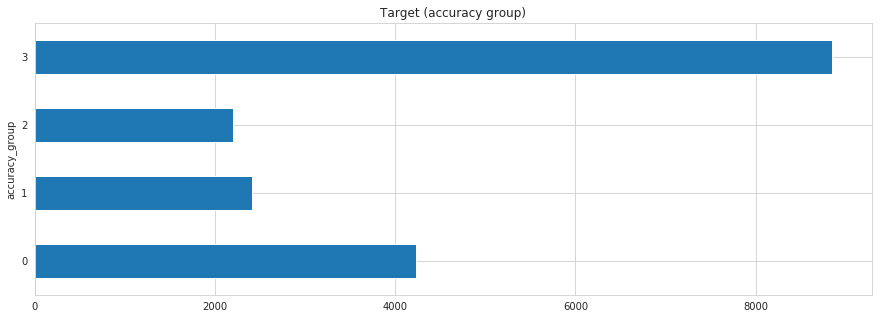

In [36]:
# target
train_labels.groupby('accuracy_group')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Target (accuracy group)')
plt.show()

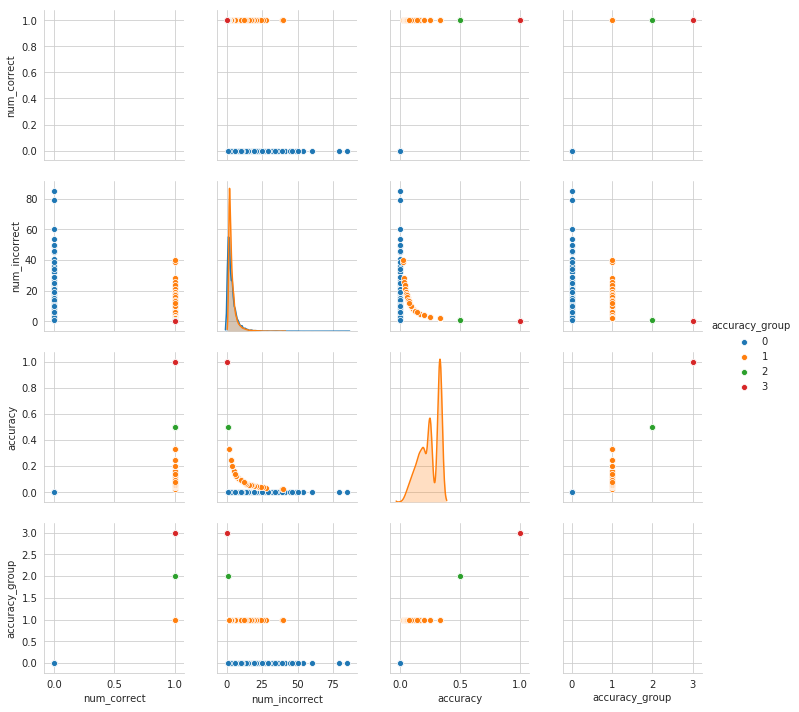

In [37]:
sns.pairplot(train_labels, hue='accuracy_group')
plt.show()

Text(0.5, 1.0, 'Counts of titles')

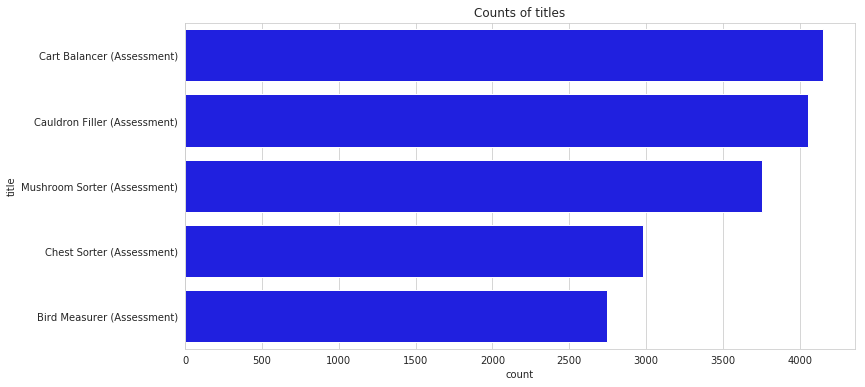

In [38]:
# count of title
plt.figure(figsize=(12,6))
sns.countplot(y="title", data=train_labels, color="blue", order = train_labels.title.value_counts().index)
plt.title("Counts of titles")

Text(0.5, 1.0, 'Counts of accuracy group')

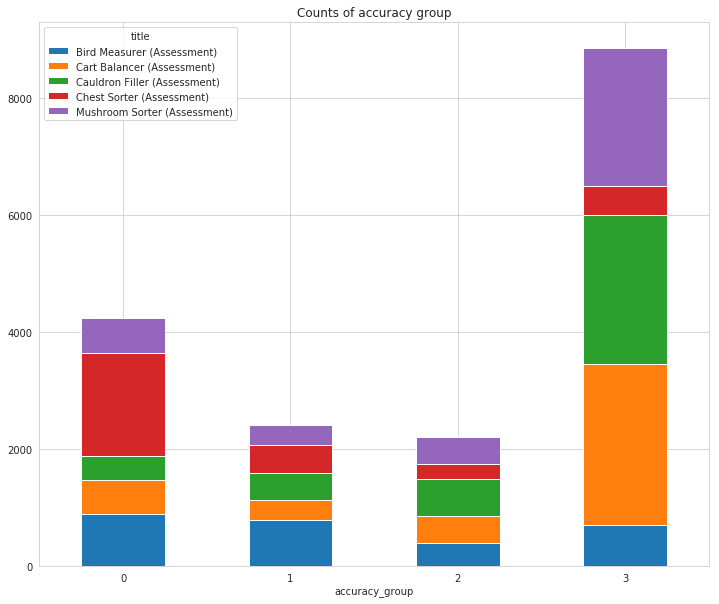

In [39]:
se = train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'].count().unstack('title')
se.plot.bar(stacked=True, rot=0, figsize=(12,10))
plt.title("Counts of accuracy group")
# you can see that a lot of Chest Sorter assessments were never solved.
# Bird Measurer also seems hard with a relatively small amount solved on the first attempt.
# which means that there's difference in the difficulty of games

Now the question arises: Could there be installation_id's who did assessments (we have already taken out the ones who never took one), but without results in the train_labels? Surprisingly, yes there are 628 examples.

In [40]:
train[~train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

628

In [41]:
# remove such instances
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 17)

In [42]:
print("current installation_ids: ", train["installation_id"].nunique())

current installation_ids:  3614


# test.csv

In [43]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10 16:50:24.910000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10 16:50:55.503000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10 16:51:51.805000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10 16:53:12.825000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10 16:54:12.115000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [44]:
test.shape

(1156414, 11)

In [45]:
# Same for test
test['timestamp'] = pd.to_datetime(test['timestamp'])
test['date'] = test['timestamp'].dt.date
test['hour'] = test['timestamp'].dt.hour
test['weekday_name'] = test['timestamp'].dt.weekday_name

In [46]:
print("no of installation_ids in test: ", test.installation_id.nunique())
print("no of installation_ids in ss  : ", ss.shape[0])
# So we have 1.1 million rows on a thousand unique installation_ids in the test set. 
# Below, you can see that we have this same amount of rows in the sample submission.
# This means that there are no installation_ids without assessment in the test set indeed.

no of installation_ids in test:  1000
no of installation_ids in ss  :  1000


In [47]:
test.groupby("installation_id")["type"].value_counts()

installation_id  type      
00abaee7         Activity        454
                 Game            373
                 Assessment       27
                 Clip             14
01242218         Activity       1356
                 Game           1089
                 Assessment      245
                 Clip             29
017c5718         Activity        143
                 Clip              6
                 Assessment        1
01a44906         Activity        145
                 Game             78
                 Clip             10
                 Assessment        1
01bc6cb6         Game            708
                 Activity        226
                 Clip             17
                 Assessment        1
02256298         Activity        515
                 Game            296
                 Assessment       16
                 Clip              6
0267757a         Game            784
                 Activity         90
                 Clip             13
          

In [48]:
# last row in each installation_id data is always assessment
#for i in list(test.installation_id.unique()): 
#    print(test[test.installation_id == i].iloc[-1]["type"])

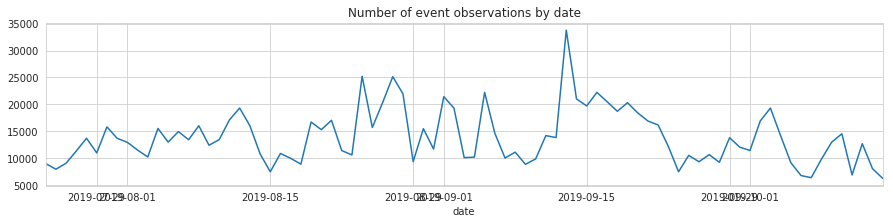

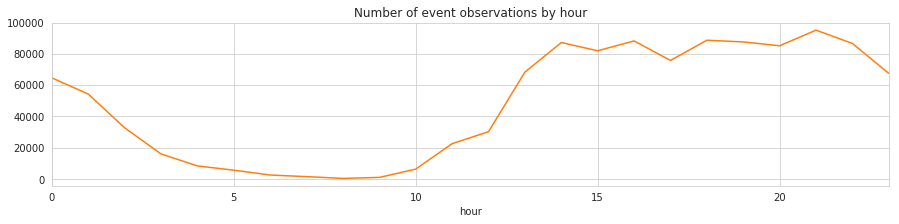

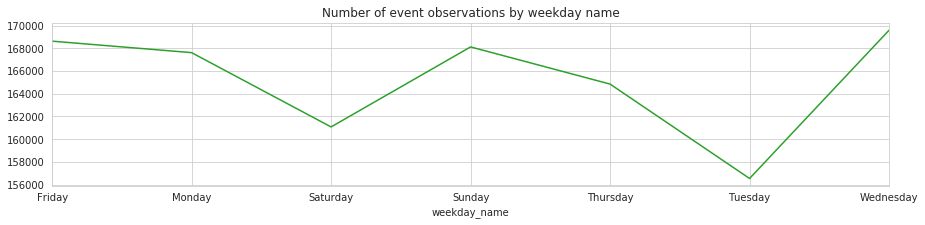

In [49]:
test.groupby('date')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by date", color=my_pal[0])
plt.show()
test.groupby('hour')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by hour", color=my_pal[1])
plt.show()
test.groupby('weekday_name')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by weekday name", color=my_pal[2])
plt.show()

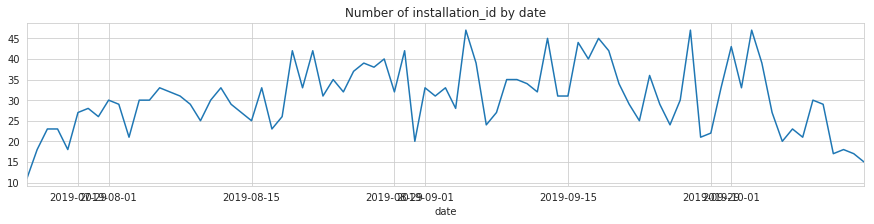

In [50]:
# can be seen as cyclic trend in the middle part of analysis period
test.groupby('date')['installation_id'].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of installation_id by date", color=my_pal[0])
plt.show()

# specs.csv

In [51]:
specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 3 columns):
event_id    386 non-null object
info        386 non-null object
args        386 non-null object
dtypes: object(3)
memory usage: 9.2+ KB


In [52]:
specs.describe()

,event_id,info,args
count,386,386,386
unique,386,168,191
top,28f975ea,This event occurs when the player clicks on th...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
freq,1,17,25


In [53]:
specs.head(5)

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [54]:
## what is writtern in info?
for i in range(specs["info"].nunique()):
    print(i, specs["info"].unique()[i])
    print("")

0 The end of system-initiated feedback (Correct) event occurs when the game finishes delivering feedback to the player in response to a correct round attempt (pressing the go button with the correct answer). It contains information that describes the duration and content of the instruction, and will likely occur in conjunction with a beat round event. These events are used to determine the effectiveness of the feedback. We can answer questions like, "how much time elapsed while the game was presenting feedback?"

1 The end of system-initiated feedback (Incorrect) event occurs when the game finishes delivering feedback to the player in response to an incorrect round attempt (pressing the go button with the incorrect answer). It contains information that describes the content of the instruction. These events are used to determine the effectiveness of the feedback. We can answer questions like, "how much time elapsed while the game was presenting feedback?"

2 The end of system-initiated 

In [55]:
#for i in range(specs["args"].nunique()): # train, testのevent_data変数に書かれている情報を示している。
#    print(i, specs["args"].unique()[i])
#    print("")

In [56]:
specs[specs.event_id == "bb3e370b"].iloc[0]["info"]

'This event occurs when the player picks up a bottle by clicking on it, or begins dragging a bottle. It contains information about the bottle that was picked up and the position of the click.'

In [57]:
# what's included in info? probably importance phrases for analysis
specs["click"] = specs["info"].apply(lambda x: 1 if "click" in x else 0)
specs["drag"] = specs["info"].apply(lambda x: 1 if "drag" in x else 0)
specs["place"] = specs["info"].apply(lambda x: 1 if "place" in x else 0)
specs["help button"] = specs["info"].apply(lambda x: 1 if "help button" in x else 0)
specs["again button"] = specs["info"].apply(lambda x: 1 if "again button" in x else 0)
specs["finish round"] = specs["info"].apply(lambda x: 1 if "finishes a round" in x else 0)
specs["successful"] = specs["info"].apply(lambda x: 1 if "successfully" in x else 0)
specs["skip button"] = specs["info"].apply(lambda x: 1 if "skip button" in x else 0)
specs["hint"] = specs["info"].apply(lambda x: 1 if "hint" in x else 0)
specs["done button"] = specs["info"].apply(lambda x: 1 if "done button" in x else 0)
specs["quit"] = specs["info"].apply(lambda x: 1 if "quit" in x else 0)
specs["video starts"] = specs["info"].apply(lambda x: 1 if "video starts" in x else 0)
specs["victory screen"] = specs["info"].apply(lambda x: 1 if "victory screen" in x else 0)
specs["tutorial"] = specs["info"].apply(lambda x: 1 if "tutorial" in x else 0)
specs["fill"] = specs["info"].apply(lambda x: 1 if "fill" in x else 0)
specs["fill"].value_counts()

0    373
1     13
Name: fill, dtype: int64

In [58]:
specs[specs.hint ==1].iloc[0]["info"]

"This event occurs when the player clicks on the character that provides a hint (Sorry, I don't know his name). It contains information about the state of the game when the player chooses to seek help. This event is usually followed by a 3010 (system-initiated instruction) event. It helps identify points that players feel are too difficult."

# sample_submission.csv

In [59]:
ss.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
